# Time period and sigma

**Figure 4**

### Author: Chris Wyburn-Powell, [github](https://github.com/chrisrwp/synthetic-ensemble/SIA/Time_period_and_sigma.ipynb)

**Input**: <br>
Sea ice area for 6 CLIVAR LE models and observations from HadISST1 historical and RCP8.5. <br>

**Output**: <br>
- $\sigma_{LE}$, $\sigma_{mem}$ and $\sigma_{obs}$ using a range of different time period lengths from 6 year to the full length of the linear trend

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import numpy as np
# import scipy.signal as sig
import scipy.signal as signal 
import scipy 
import math as m
import xarray as xr
import datetime
import dask
print(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d"))

data_path = '/glade/scratch/cwpowell/Synthetic_ensemble/'

19:28 UTC Wed 2022-04-27


In [102]:
# from dask_jobqueue import PBSCluster
# from dask.distributed import Client

# cluster = PBSCluster(cores    = 1,
#                      memory   = '10GB',
#                      queue    = 'economy',
#                      walltime = '00:29:00')

# cluster.scale(8)
# client = Client(cluster)
# client

In [3]:
model_names        = ['CanESM2', 'CESM1', 'CSIRO_MK36',  'GFDL_CM3', 'GFDL_ESM2M', 'MPI_ESM1']
model_print_names  = ['CanESM2', 'CESM1', 'CSIRO MK3.6', 'GFDL CM3', 'GFDL ESM2M', 'MPI ESM1']
obs_names          = ['HadISST1']

month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
               'August', 'September', 'October', 'November', 'December']


mem_len   = [50,  40,  30,  20,  30,  100]
start_yrs = [1950,1920,1850,1920,1950,1850]
colors    = ['m', 'b', 'g', 'orange', 'k', 'tab:olive']

## Load SIA data from models and observations

In [3]:
HadISST1_areas = xr.open_dataset(data_path+'Raw_data/observations/HadISST/HadISST_ice_area.nc')
HadISST1_SIC = xr.open_dataset(data_path+'Raw_data/observations/HadISST/HadISST_ice.nc')

HadISST_NH = HadISST1_SIC['sic'].where(HadISST1_SIC['latitude']>30, drop=True)

HadISST_SIA = []
for month_ in np.arange(1,13):
    HadISST_SIA.append((HadISST_NH.sel(time=HadISST_NH['time.month']==month_) * HadISST1_areas.where(HadISST1_areas['latitude']>30,drop=True)).sum('latitude').sum('longitude'))
    
HadISST_SIA = xr.concat(HadISST_SIA, dim='time')
HadISST_SIA = HadISST_SIA/1e12
HadISST_SIA = HadISST_SIA.rename({'cell_area': 'SIA'})
HadISST_SIA = HadISST_SIA.sortby('time')

HadISST1_SIA_79_20 = xr.open_dataset(data_path+'Raw_data/observations/HadISST/HadISST1_SIA_SIE_79-20_filled.nc')

Had_SIA = xr.concat((HadISST_SIA.sel(time=slice('1850-01', '1999-12')), HadISST1_SIA_79_20.sel(time=slice('2000-01','2020-12'))), dim='time')
Had_SIA = Had_SIA['SIA']

In [4]:
#load the SIA from models 1850-2100
SIA_models = xr.open_dataset(data_path+'SIA/SIA_SIE_SIV/CLIVAR_SIA_1850_2100_RCP85.nc')

# Use lowpass filtering for detrending

In [5]:
def resample_boot2(time_period, data, resamp_n):
    '''
    Resample a 1D time series using a 2 year block boostrap size with replacement
    
    Parameters
    ----------
    time_period : integer,
        For 1979-2020 use 42 as the total number of years in that time period
    data : 1 dimensional xarray dataarray,
        For 1979-2020 this is an array of shape [42] 
    resamp_n: int
        Number of resamplings
    
    Returns
    ----------
        2D xarray dataarray object of n resamplings of the input data, shape: (time_period, resamp_n)
    '''  
    #create an xarray dataarray of indexes for half the length of the time period, year_i coordinates 1,3,5...
    boot_2_first_ind = xr.DataArray(data   = np.random.randint(0,time_period-2, (resamp_n,int(time_period/2))), 
                                    coords = {'resampling':np.arange(1,resamp_n+1,1), 'year_i':np.arange(1,time_period+1,2)},
                                    dims   = ['resampling', 'year_i'])

    #create an identical dataarray but with each element incremented by 1, year_i coordinates 2,4,6....
    boot_2_second_ind = (boot_2_first_ind+1).copy()
    boot_2_second_ind['year_i'] = np.arange(2,time_period+2,2)

    #concatenate the two arrays with the coordinates in order, this allows a 2 year block boostrap size
    all_boot_2_ind = xr.concat((boot_2_first_ind, boot_2_second_ind), dim='year_i').sortby('year_i')
    
    #create an array with the starting element of the flattened array for each resampling 0, 42, 84...
    ind_base = np.repeat(np.arange(0,time_period*resamp_n,time_period),time_period)
    
    #add together the base indexes (0,42,84...) with the randomly chosen indexes within the original data
    ind_1_d = np.ravel(all_boot_2_ind) + ind_base
    
    #copy the original data 1000 times as a 1D array so it will have the same indexes as we just made for ind_1_d
    data_1000 = np.ravel(np.tile(data,(time_period,resamp_n)))
    
    #select the randomly generated indexes from the flattened copied original data, reshape and save to xarray dataarray
    resampled_boot_2 = xr.DataArray(data = np.reshape(data_1000[ind_1_d], (resamp_n, time_period)),
                                    coords = {'resampling':np.arange(1,resamp_n+1,1), 'year_i':np.arange(1,time_period+1,1)},
                                    dims   = ['resampling', 'year_i'])

    return(resampled_boot_2)

In [6]:
def filt_lowpass(data, sample_freq, cutoff, order):
    '''
    Filter a 1D time series using a lowpass Butterworth filter. 
    Uses scipy.signal.butter and scipy.signal.filtfilt
    
    Parameters
    ----------
    data : 1 dimensional xarray dataarray,
        For 1979-2020 this is an array of shape [42] 
    sample_freq: float,
        The sampling frequency of the input data, typically sample_freq=1 [year]
    cutoff: float,     
        The fraction of the nyquist frequency. To filter with a 2-year lowpass filter with sample_freq=1, cutoff=0.25
    order: int
        The order of the Butterworth filter, typically 4-6
    
    Returns
    ----------
        1D numpy array of the same shape as the input data
    '''  
    
    nyquist = sample_freq / 2 # 0.5 times the sampling frequency
    b, a = signal.butter(order, cutoff, btype='lowpass') #low pass filter
    filtered = signal.filtfilt(b, a, data) #apply the filter forward and backward
    
    return(filtered)

## Detrend with a 2 year lowpass filter for 1953-2020
**N.B. if we extend the time series much beyond 2020 we end up with some models with very low values, so sigma values will be near zero if the end of the time period is selected**

In [36]:
#detrend models with lowpass filter for years 1953-2052
anoms_1953_2020 = {}
for model_i, model_name in enumerate(model_names):
    month_anoms = []
    for month_ in [3,9]:
        mem_anoms = []
        for mem_ in np.arange(1,mem_len[model_i]+1):
            mem_data = SIA_models[model_name].sel(member=mem_).sel(time=SIA_models['time.month']==month_).sel(time=slice('1953','2020'))
            mem_filt = filt_lowpass(mem_data, sample_freq=1, cutoff=0.25, order=5)
            mem_anoms.append(mem_data - mem_filt)
        
        month_anoms.append(xr.concat((mem_anoms),dim='member'))

    anoms_1953_2020[model_name] = xr.concat((month_anoms),dim='time')
anoms_1953_2020 = xr.Dataset(anoms_1953_2020)
anoms_1953_2020['member'] = np.arange(1,101)

In [30]:
#detrend obs with lowpass filter for years 1953-2020
HadISST1_anoms_1953_2020 = []
for month_ in [3,9]:
    obs_data = Had_SIA.sel(time=Had_SIA['time.month']==month_).sel(time=slice('1953','2020'))
    obs_filt = filt_lowpass(obs_data, sample_freq=1, cutoff=0.25, order=5)
    HadISST1_anoms_1953_2020.append(obs_data - obs_filt)
    
HadISST1_anoms_1953_2020 = xr.concat((HadISST1_anoms_1953_2020),dim='month')
HadISST1_anoms_1953_2020['month'] = [3,9]

## Resample for different time periods
### $\sigma_{LE}$

In [124]:
sigma_LE = {}

for model_i, model_name in enumerate(model_names):
    print(datetime.datetime.now(), model_name)
    
    sigma_LE_month = []
    for month_ in [3,9]:
        if model_name == 'MPI_ESM1':
            all_mem = anoms_1953_2020[model_name].sel(time=anoms_1953_2020['time.month']==month_)
        else:
            all_mem = anoms_1953_2020[model_name].sel(time=anoms_1953_2020['time.month']==month_).sel(member=slice('1',str(mem_len[model_i])))

        data_reduced_time = []
        for time_period in np.arange(6,67,2):

            runs = []
            for run in range(100):
                rand_start = np.random.randint(0,68-time_period) 
                runs.append(all_mem.isel(time=slice(rand_start,rand_start+time_period-1)).std('time'))

            data_reduced_time.append(xr.concat((runs), dim='run').mean('run'))

        sigma_LE_month.append(xr.concat((data_reduced_time), dim='time_period').std('member'))
    sigma_LE[model_name] = xr.concat((sigma_LE_month),dim='month')
sigma_LE = xr.Dataset(sigma_LE)
sigma_LE['time_period'] = np.arange(6,67,2)
sigma_LE['month'] = [3,9]

2022-04-07 09:22:02.826072 CanESM2
2022-04-07 09:22:06.639856 CESM1
2022-04-07 09:22:10.130705 CSIRO_MK36
2022-04-07 09:22:13.716998 GFDL_CM3
2022-04-07 09:22:17.345850 GFDL_ESM2M
2022-04-07 09:22:20.840366 MPI_ESM1


In [132]:
#save sigma_LE to netcdf
sigma_LE.attrs = {'Description': 'Standard deviations (between members) of Arctic sea ice area for six models (CanESM2, CESM1, CSIRO MK3.6, GFDL CM3, GFDL ESM2M, MPI ESM1). Time periods are March and September for 6-66 years along a 2 year lowpass filter detrended time series of ice area decline from 1953-2020 during historical and RCP8.5 forcing. Start dates within the linear trend are chosen at random 1000 times and the results averaged.',
                  'Units'      : 'Million square km',
                  'Timestamp'  : str(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d")),                
                  'Data source': 'CLIVAR Large Ensemble Archive (doi: 10.1038/s41558-020-0731-2)',
                  'Analysis'   : 'Python 3.7.9 - https://github.com/chrisrwp/synthetic-ensemble/SIA/Time_period_and_sigma.ipynb'}

sigma_LE.to_netcdf('/glade/scratch/cwpowell/Synthetic_ensemble_revisions/SIA/SIA_resampled/Sigma_LE_time_period_1953_2020_filtered_bootstrap_1000.nc')

### $\sigma_{mem}$

In [137]:
sigma_mem = {}

for model_i, model_name in enumerate(model_names):
    print(datetime.datetime.now(), model_name)
    
    sigma_mem_month = []
    for month_ in [3,9]:
        print(datetime.datetime.now(), month_)
        
        member_time_periods = []
        for mem_ in np.arange(1,mem_len[model_i]+1):
            
            mem_data = anoms_1953_2020[model_name].sel(time=anoms_1953_2020['time.month']==month_).sel(member=mem_)

            data_reduced_time = []
            for time_period in np.arange(6,67,2):

                runs = []
                for run in range(10):
                    rand_start = np.random.randint(0,68-time_period) 
                    runs.append(resample_boot2(time_period, mem_data.isel(time=slice(rand_start,rand_start+time_period-1)), 1000).std('year_i').std('resampling'))

                data_reduced_time.append(xr.concat((runs), dim='run').mean('run'))
            
            member_time_periods.append(xr.concat((data_reduced_time),dim='time_period'))
        
        mem_temp = xr.concat((member_time_periods), dim='member')
        mem_temp['member'] = np.arange(1,mem_len[model_i]+1)
        sigma_mem_month.append(mem_temp)
        
    sigma_mem[model_name] = xr.concat((sigma_mem_month),dim='month')

sigma_mem = xr.Dataset(sigma_mem)
sigma_mem['time_period'] = np.arange(6,67,2)
sigma_mem['month'] = [3,9]

In [131]:
sigma_mem.attrs = {'Description': 'Resampled standard deviations of Arctic sea ice area for six models (CanESM2, CESM1, CSIRO MK3.6, GFDL CM3, GFDL ESM2M, MPI ESM1). Time periods are March and September for 6-66 years along a 2 year lowpass filter detrended time series of ice area decline from 1953-2020 during historical and RCP8.5 forcing. Start dates within the linear trend are chosen at random 10 times and the results averaged. Models are resampled 1000 times with a 2 year bootstrap size.',
                   'Units'      : 'Million square km',
                   'Timestamp'  : str(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d")),                
                   'Data source': 'CLIVAR Large Ensemble Archive (doi: 10.1038/s41558-020-0731-2)',
                   'Analysis'   : 'Python 3.7.9 - https://github.com/chrisrwp/synthetic-ensemble/SIA/Time_period_and_sigma.ipynb'}

sigma_mem.to_netcdf('/glade/scratch/cwpowell/Synthetic_ensemble_revisions/SIA/SIA_resampled/Sigma_mem_time_period_1953_2020_filtered_resample_1000.nc')

### $\sigma_{obs}$

In [136]:
sigma_obs = []
for month_ in [3,9]:
    data_month = HadISST1_anoms_1953_2020.sel(month=month_)
    
    time_period_resamps = []
    for time_period in np.arange(6,67,2):
        print(datetime.datetime.now(), time_period)

        runs = []
        for run in range(1000):
            rand_start = np.random.randint(0,100-time_period) 
            runs.append(resample_boot2(time_period, HadISST1_anoms_1953_2020.isel(time=slice(rand_start,rand_start+time_period-1)), 1000).std('year_i').std('resampling'))

        time_period_resamps.append(xr.concat((runs), dim='run').mean('run'))

    sigma_obs.append(xr.concat((time_period_resamps), dim='time_period'))
    
sigma_obs = xr.concat((sigma_obs),dim='month')
sigma_obs['time_period'] = np.arange(6,67,2)
sigma_obs['month'] = [3,9]

In [135]:
sigma_obs.attrs = {'Description': 'Resampled standard deviations of Arctic sea ice area for six models (CanESM2, CESM1, CSIRO MK3.6, GFDL CM3, GFDL ESM2M, MPI ESM1). Time periods are March and September for 6-66 years along a 2 year lowpass filter detrended time series of ice area decline from 1953-2020 during historical and RCP8.5 forcing. Start dates within the linear trend are chosen at random 1000 times and the results averaged. Detrended anomalies are resampled 1000 times with a 2 year bootstrap size.',
                   'Units'      : 'Million square km',
                   'Timestamp'  : str(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d")),                
                   'Data source': 'CLIVAR Large Ensemble Archive (doi: 10.1038/s41558-020-0731-2)',
                   'Analysis'   : 'Python 3.7.9 - https://github.com/chrisrwp/synthetic-ensemble/SIA/Time_period_and_sigma.ipynb'}

sigma_obs.to_netcdf('/glade/scratch/cwpowell/Synthetic_ensemble_revisions/SIA/SIA_resampled/Sigma_obs_time_period_1953_2020_filtered_bootstrap_1000.nc')

## Plot filtered version of fig 4

In [150]:
sigma_LE.close()
sigma_mem.close()
sigma_obs.close()

sigma_LE = xr.open_dataset('/glade/scratch/cwpowell/Synthetic_ensemble_revisions/SIA/SIA_resampled/Sigma_LE_time_period_1953_2020_filtered_bootstrap_1000.nc')
sigma_mem = xr.open_dataset('/glade/scratch/cwpowell/Synthetic_ensemble_revisions/SIA/SIA_resampled/Sigma_mem_time_period_1953_2020_filtered_resample_1000.nc')
sigma_obs = xr.open_dataarray('/glade/scratch/cwpowell/Synthetic_ensemble_revisions/SIA/SIA_resampled/Sigma_obs_time_period_1953_2020_filtered_bootstrap_1000.nc')

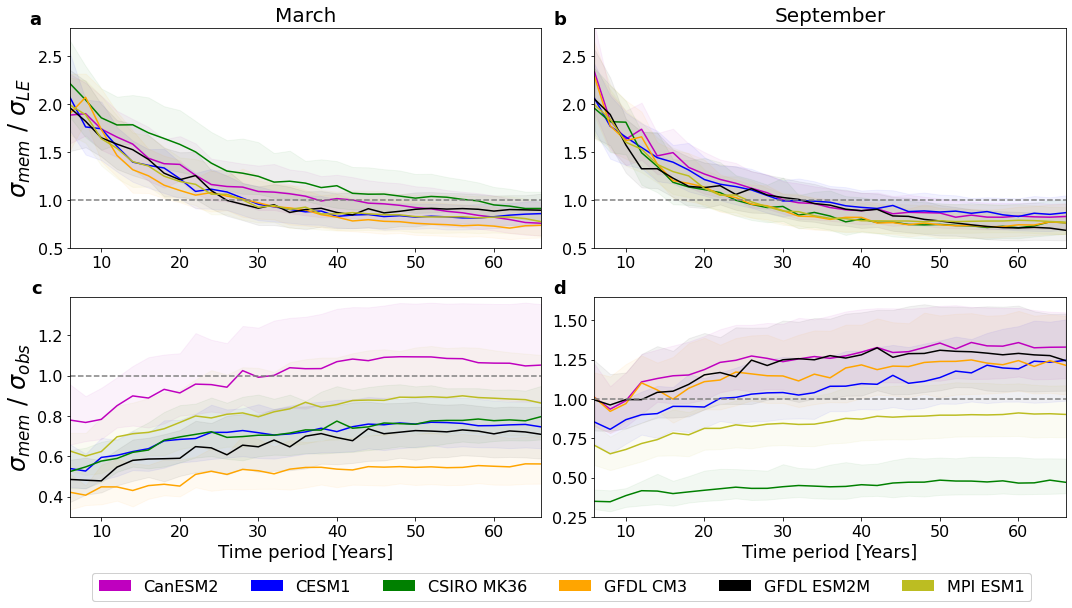

In [151]:
fig, axes = plt.subplots(2,2,figsize=[15,8])

for i, month_ in enumerate([3,9]):
    
    LE = sigma_LE.sel(month=month_)
    mem = sigma_mem.sel(month=month_)
    obs = sigma_obs.sel(month=month_)
    
    ########### sigma mem / sigma LE ########### 
    for model_i, model_name in enumerate(model_names):
        (mem[model_name].median('member') / LE[model_name]).plot(ax=axes[0][i], c=colors[model_i], label=model_print_names[model_i])

        axes[0][i].fill_between(mem[model_name]['time_period'], (mem[model_name].mean('member')-mem[model_name].std('member'))/LE[model_name], 
                               (mem[model_name].mean('member')+mem[model_name].std('member'))/LE[model_name], color=colors[model_i], alpha=0.05)

    axes[0][i].axhline(1, c='0.5', linestyle='--')
    axes[0][i].set_ylim(0.25,3.5)  
    # axes[0][i].set_yticklabels(np.arange(0,3.6,0.5), fontsize=16)
    axes[0][i].set_xlabel('')
    axes[0][i].set_ylabel('')
    # axes[0][i].grid()
    if i==0:
        axes[0][i].set_xlim(6,66)
    else:
        axes[0][i].set_xlim(6,66)

    ########### sigma mem / sigma obs ########### 
    for model_i, model_name in enumerate(model_names):

        (mem[model_name].median('member') / obs).plot(ax=axes[1][i], c=colors[model_i], label=model_print_names[model_i])

        axes[1][i].fill_between(mem['time_period'], (mem[model_name].mean('member')-mem[model_name].std('member'))/obs, 
                        (mem[model_name].mean('member')+mem[model_name].std('member'))/obs, color=colors[model_i], alpha=0.05)

    axes[1][i].axhline(1, c='0.5', linestyle='--')
    axes[1][i].set_xlabel('')
    axes[1][i].set_ylabel('')
    # axes[1][i].grid()
    axes[1][i].set_xlim(6,66)    

    ########### add features to the whole plot ###########    
legend_elements = [Patch(facecolor=colors[0], label='CanESM2'),
                   Patch(facecolor=colors[1], label='CESM1'),
                   Patch(facecolor=colors[2], label='CSIRO MK36'),
                   Patch(facecolor=colors[3], label='GFDL CM3'),
                   Patch(facecolor=colors[4], label='GFDL ESM2M'),
                   Patch(facecolor=colors[5], label='MPI ESM1'),]

extra_legend = plt.legend(handles=legend_elements, bbox_to_anchor=(-0.07, -0.38), loc='lower center', borderaxespad=0, ncol=6, fontsize=16)
plt.gca().add_artist(extra_legend);

axes[0][0].set_title('March', fontsize=20)
axes[0][1].set_title('September', fontsize=20)
axes[1][0].set_title('')
axes[1][1].set_title('')

axes[0][0].set_ylim(0.5,2.8)
axes[0][1].set_ylim(0.5,2.8)
axes[1][0].set_ylim(0.3,1.39)
axes[1][1].set_ylim(0.25,1.65)

axes[0][0].tick_params(axis='both', which='major', labelsize=16)
axes[0][1].tick_params(axis='both', which='major', labelsize=16)
axes[1][0].tick_params(axis='both', which='major', labelsize=16)
axes[1][1].tick_params(axis='both', which='major', labelsize=16)

axes[0][0].set_ylabel(r'$\sigma_{mem} \ / \ \sigma_{LE}$', fontsize=24)
axes[1][0].set_ylabel(r'$\sigma_{mem} \ / \ \sigma_{obs}$', fontsize=24)
axes[1][0].set_xlabel('Time period [Years]', fontsize=18)
axes[1][1].set_xlabel('Time period [Years]', fontsize=18)

axes[0][0].text(-0.06, 1.08, 'a', transform=axes[0][0].transAxes, fontsize=18, fontweight='bold', va='top', ha='right');
axes[0][1].text(-0.06, 1.08, 'b', transform=axes[0][1].transAxes, fontsize=18, fontweight='bold', va='top', ha='right');
axes[1][0].text(-0.06, 1.08, 'c', transform=axes[1][0].transAxes, fontsize=18, fontweight='bold', va='top', ha='right');
axes[1][1].text(-0.06, 1.08, 'd', transform=axes[1][1].transAxes, fontsize=18, fontweight='bold', va='top', ha='right');

plt.tight_layout()
fig.savefig('/glade/scratch/cwpowell/Synthetic_ensemble_revisions/SIA/figures/Time_period_and_sigma/Ratio_time_period_same_all_models_obs_79_filtered.pdf', 
            bbox_inches='tight')
# fig.savefig('/glade/scratch/cwpowell/Synthetic_ensemble/SIA/figures/Time_period_and_sigma/Ratio_time_period_same_all_models_obs_79.png', 
#             bbox_inches='tight', dpi=400)

# Plot different ways of obtaining the dates for the linear trend

In [111]:
CanESM2_09 = SIA_models['CanESM2'].sel(time=SIA_models['time.month']==9).mean('member').sel(time=slice('1950','2100'))

In [1]:
CanESM2_09_filt = sig.savgol_filter(CanESM2_09.values, 21, 1)
CanESM2_09_filt_grad = np.gradient(CanESM2_09_filt)
CanESM2_09_filt_grad_filt = sig.savgol_filter(CanESM2_09_filt_grad, 21,1)
plt.plot(CanESM2_09_filt_grad)
plt.plot(CanESM2_09_filt_grad_filt);
plt.title('1st derivative of smoothed data');

In [2]:
CanESM2_09_filt_grad_filt_grad = np.gradient(CanESM2_09_filt_grad_filt)
CanESM2_09_filt_grad_filt_grad_filt = sig.savgol_filter(CanESM2_09_filt_grad_filt_grad, 21, 1)
plt.plot(CanESM2_09_filt_grad_filt_grad)
plt.plot(CanESM2_09_filt_grad_filt_grad_filt)
plt.axhline(0, c='k')
plt.title('2nd derivative of smoothed 1st derivative');

In [3]:
model_name = 'CanESM2'
model_i = 0
month_ = 9

SIA_model = SIA_models[model_name].sel(time=SIA_models['time.month']==month_).mean('member').sel(time=slice(str(start_yrs[model_i]),'2100'))

full_yrs = np.arange(start_yrs[model_i],2101)

plt.plot(full_yrs, SIA_model.values)
plt.plot(full_yrs, sig.savgol_filter(SIA_model.values, 21, 1))

model_filt_2nd =  sig.savgol_filter(np.gradient(sig.savgol_filter(np.gradient(sig.savgol_filter(SIA_model.values,21,1)), 21,1)), 21,1)
                                                                                                 
max_2nd = np.argmax(model_filt_2nd)
min_2nd = np.argmin(model_filt_2nd)

plt.axvline(full_yrs[max_2nd], c='0.5', linestyle='--')
plt.axvline(full_yrs[min_2nd], c='0.5', linestyle='--')

lin_x_vals = np.arange(full_yrs[min_2nd], full_yrs[max_2nd]+1, 1)

lin_coef = np.polyfit(lin_x_vals, SIA_model.isel(time=slice(min_2nd, max_2nd+1)).values, 1)
plt.plot(lin_x_vals, lin_coef[0]*lin_x_vals + lin_coef[1])

## Brute force - find optimal linear trend minimum of 40 years

In [4]:
model_i = 3
model_name = model_names[model_i]
month_ = 3

trend_intervals = np.arange(40,111)

SIA_data = SIA_models[model_name].sel(time=SIA_models['time.month']==month_).mean('member').sel(time=slice(str(start_yrs[model_i]),'2100'))
full_yrs = np.arange(start_yrs[model_i],2101)

best_start = []
best_rms = []

for trend_interval in trend_intervals:
    trend_interval_rms = []
    for i in range(len(SIA_data)-trend_interval-1):
        #make a linear trend for 0th to trend_interval, then 1st to trend_interval+1.....
        coefs = np.polyfit(full_yrs[i:i+trend_interval], SIA_data.isel(time=slice(i, i+trend_interval)).values, 1)
        trend = (full_yrs[i:i+trend_interval] * coefs[0]) + coefs[1]
        #compute the residuals from the linear trend
        residuals = SIA_data.isel(time=slice(i, i+trend_interval)).values - trend
        #append the root mean square (rms) of the detrended data
        trend_interval_rms.append(np.sqrt(np.mean(residuals**2)))

    best_start.append(np.argmin(trend_interval_rms))
    best_rms.append(np.min(trend_interval_rms))
        

##### make a summary plot for that month and model #####
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax3 = ax2.twiny()
ax1.plot(full_yrs, SIA_data, c=colors[model_i])
ax1.set_ylabel(r'$Arctic \ SIA \ [10^6 \ km^2]$', color=colors[model_i])
ax1.set_xlabel('Year', color=colors[model_i])
ax1.tick_params(axis='both', colors=colors[model_i])

ax2.plot(np.array(best_start) + start_yrs[model_i], trend_intervals, c='0.5')
ax2.plot(np.array(best_start) + start_yrs[model_i] + trend_intervals, trend_intervals, c='0.5')
ax2.tick_params(axis='y', colors='0.5')
ax2.set_ylabel('Length of linear trend [Years]', color='0.5')

ax3.plot(best_rms, trend_intervals, c='r')
ax3.tick_params(axis='x', colors='r')
ax3.set_xlabel(r'$RMS \ of \ linear \ trend \ resididuals \ [10^6 \ km^2]$', color='r')

plt.title(model_print_names[model_i], fontsize=14);

In [5]:
#test out the linear trend for a given trend_interval, model, month, and start element
model_name = 'CanESM2'
model_i = 0

month_ = 9

SIA_data = SIA_models[model_name].sel(time=SIA_models['time.month']==month_).mean('member').sel(time=slice(str(start_yrs[model_i]),'2100'))
full_yrs = np.arange(start_yrs[model_i],2101)

trend_interval = 80
i = 50

coefs = np.polyfit(full_yrs[i:i+trend_interval], SIA_data.isel(time=slice(i, i+trend_interval)).values, 1)
trend = (full_yrs[i:i+trend_interval] * coefs[0]) + coefs[1]
plt.plot(full_yrs, SIA_data.values)
plt.plot(full_yrs[i:i+trend_interval], trend)

residuals = SIA_data.isel(time=slice(i, i+trend_interval)).values - trend
rms = np.sqrt(np.mean(residuals**2))
print(rms)

# Detrend the SIA relative to the ensemble mean for the chosen linear trend

## Define the linear trend limits for March and September

In [5]:
#select the longest linear trend for each model for September and March, also observations
# March_linear     = [[1982,2065], [2015,2090], [1977,2054], [1985,2044], [1970,2040], [1970,2067], [1953,2020]]
# September_linear = [[1972,2032], [1995,2045], [1985,2044], [1985,2028], [1970,2040], [1985,2045], [1965,2020]]

# Mar_linear_xr = xr.DataArray(data=March_linear, coords={'dataset': model_names+obs_names, 'limit': ['start', 'end']}, dims=['dataset', 'limit'])
# Sep_linear_xr = xr.DataArray(data=September_linear, coords={'dataset': model_names+obs_names, 'limit': ['start', 'end']}, dims=['dataset', 'limit'])

# linear_trend_dates = xr.Dataset({'03': Mar_linear_xr, '09':Sep_linear_xr})

#want to detrend for March 1965-2066 (for mem/LE) and 1953-2020 (for mem/obs)
#September 1970-2040 (for mem/LE) and 1965-2020 (for mem/obs)

mar_yrs = [['1965','2066'], ['1953','2020']]
sep_yrs = [['1970','2040'], ['1965','2020']]

## Detrend based on thses dates

In [100]:
def detrend_ens_ind(data, start_yr, end_yr, mem_len):
    '''
    detrends relative to the ensemble mean and the individual member
    '''

    #detrend with ensemble mean 
    coefs = np.polyfit(np.arange(start_yr,end_yr+1), data.mean('member').values, 1)
    ens_trend = xr.DataArray(data=(np.arange(start_yr,end_yr+1)*coefs[0])+coefs[1], coords={'time':data['time']}, dims='time')
    anomalies_ens = data - ens_trend

    #detrend individual members
    anomalies_ind = []
    for mem_i, mem in enumerate(np.arange(1,mem_len+1)):
        coefs = np.polyfit(np.arange(start_yr,end_yr+1), data.sel(member=mem).values, 1)
        tred_ind = (np.arange(start_yr, end_yr+1) * coefs[0]) + coefs[1]
        anomalies_ind.append(xr.DataArray(data=data.sel(member=mem)-tred_ind, coords={'time':data['time']}, dims='time'))

    anomalies_ind = xr.concat((anomalies_ind), dim='member')
    anomalies_ind['member'] = np.arange(1,mem_len+1)

    return(anomalies_ens, anomalies_ind)

In [15]:
#detrend all model members

detrended_ens_obs_LE = []
detrended_ind_obs_LE = []

for i in range(2):

    all_detrended_ens = []
    all_detrended_ind = []

    for model_i, model_name in enumerate(model_names):

        model_detrended_ens = []
        model_detrended_ind = []

        for month_ in [3,9]:
            if month_ == 3:
                yrs = mar_yrs[i]
            else:
                yrs = sep_yrs[i]

            data_ = SIA_models[model_name].sel(time=SIA_models['time.month']==month_).sel(time=slice(yrs[0],yrs[1])).sel(member=slice(0,mem_len[model_i]))
            detrend_temp = detrend_ens_ind(data_, int(yrs[0]),int(yrs[1]), mem_len[model_i])

            model_detrended_ens.append(detrend_temp[0])
            model_detrended_ind.append(detrend_temp[1])

        all_detrended_ens.append(xr.concat((model_detrended_ens), dim='time'))
        all_detrended_ind.append(xr.concat((model_detrended_ind), dim='time'))

    all_detrended_ens = xr.concat((all_detrended_ens), dim='model')
    all_detrended_ind = xr.concat((all_detrended_ind), dim='model')

    all_detrended_ens['model'] = model_names
    all_detrended_ind['model'] = model_names
    
    detrended_ens_obs_LE.append(all_detrended_ens)
    detrended_ind_obs_LE.append(all_detrended_ind)
    
detrended_ens_obs_LE = xr.concat((detrended_ens_obs_LE), dim='comparison')
detrended_ind_obs_LE = xr.concat((detrended_ens_obs_LE), dim='comparison')

detrended_ens_obs_LE['comparison'] = ['mem_LE', 'mem_obs']#label wether to use for LE or obs comparisons
detrended_ind_obs_LE['comparison'] = ['mem_LE', 'mem_obs']

In [ ]:
#detrend observations
obs_detrend = []

# start_yrs = ['1953','1965'] #start and end years
start_yrs = ['1979','1979'] #start and end years

for month_i, month_ in enumerate([3,9]):
    
    obs = Had_SIA.sel(time=Had_SIA['time.month']==month_).sel(time=slice(start_yrs[month_i], '2020'))
    
    coefs = np.polyfit(np.arange(int(start_yrs[month_i]),2021), obs.values, 1)
    obs_trend = xr.DataArray(data=(np.arange(int(start_yrs[month_i]),2021)*coefs[0])+coefs[1], coords={'time':obs['time']}, dims='time')
    
    obs_detrend.append(obs - obs_trend)

obs_detrend = xr.concat((obs_detrend), dim='time')

# Calculate $\sigma_{LE}$, $\sigma_{mem}$, $\sigma_{obs}$ for multiple time periods

In [4]:
def resample_boot2(data, resample_n):
    
    '''
    Returns resamplings of a given time series of length equal to time period 
    '''
    boot_2_first_ind = xr.DataArray(data   = np.random.randint(0,len(data)-2, (resample_n,int(len(data)/2))), 
                                    coords = {'resampling':np.arange(1,resample_n+1), 'year_i':np.arange(1,len(data)+1,2)},
                                    dims   = ['resampling', 'year_i'])

    boot_2_second_ind = (boot_2_first_ind+1).copy()
    boot_2_second_ind['year_i'] = np.arange(2,len(data)+2,2)

    all_boot_2_ind = xr.concat((boot_2_first_ind, boot_2_second_ind), dim='year_i').sortby('year_i')
    
    ind_base = np.repeat(np.arange(0,len(data)*resample_n,len(data)),len(data))
    
    ind_1_d = np.ravel(all_boot_2_ind) + ind_base

    SIA_mem_1000 = np.ravel(np.tile(data,(len(data),resample_n)))

    resample_boot_2 = xr.DataArray(data = np.reshape(SIA_mem_1000[ind_1_d], (resample_n, len(data))),
                                   coords = {'resampling':np.arange(1,resample_n+1,1), 'year_i':np.arange(1,len(data)+1,1)},
                                   dims   = ['resampling', 'year_i'])

    return(resample_boot_2.std('year_i').std('resampling'))

## $\sigma_{mem}$

In [101]:
#calculate sigma_mem via resampling and use dask
#firstly define a function for each of the members

def member_resample(member_data, mem):
    
    data_ = member_data[~np.isnan(member_data)]

    model_member_time_resampled = []
    for time_period in np.arange(6,len(data_)-1,2):

        all_runs = []
        for run_ in range(20):
            rand_start = np.random.randint(0,len(data_)-time_period-1) + int(str(data_['time'][0].values)[:4])
            all_runs.append(resample_boot2(data_.sel(time=slice(str(rand_start),str(rand_start+time_period-1))), 1000))

        all_runs = xr.concat((all_runs), dim='run')    
        model_member_time_resampled.append(all_runs.mean('run'))

    return(xr.concat((model_member_time_resampled), dim='time_period'))

In [100]:
# #calculate sigma_mem
# month_ = 9

# sigma_mem_ = {}
# for model_i, model_name in enumerate(model_names):
#     print(datetime.datetime.now(), model_name)
    
#     model_data = all_detrended_ens.sel(model=model_name).sel(time=all_detrended_ens['time.month']==month_)
#     max_t_period = len(model_data.sel(member=1)[~np.isnan(model_data).sel(member=1)]['time'])
    
#     model_resampled = []
#     for mem in np.arange(1,mem_len[model_i]+1):
#         model_resampled.append(dask.delayed(member_resample)(model_data.sel(member=mem), mem))
        
#     resampled_computed = dask.compute(*model_resampled)
    
#     model_resampled = xr.concat((resampled_computed), 'member')
#     model_resampled['time_period'] = np.arange(6,max_t_period-1,2)
#     model_resampled['member'] = np.arange(1,mem_len[model_i]+1)
    
#     sigma_mem_[model_name] = model_resampled
    
# sigma_mem_ = xr.Dataset(sigma_mem_)

In [6]:
#calculate sigma_mem for 4 different time periods  

for month_i, month_ in enumerate([3,9]):
    for i in range(2):
        if month_ == 3:
            yrs = mar_yrs[i]
        else:
            yrs = sep_yrs[i]
        
        detrended_ind = detrended_ind_obs_LE.isel(comparison=i)
        
        sigma_mem = {}
        for model_i, model_name in enumerate(model_names):
            print(datetime.datetime.now(), model_name)

            model_member_resampled = []
            for mem in np.arange(1,mem_len[model_i]+1):

                #remember to deicde if using ind or ens and change both variables on following line
                data_with_nan = detrended_ind.sel(model=model_name).sel(member=mem).sel(time=detrended_ind['time.month']==month_)
                data_ = data_with_nan[~np.isnan(data_with_nan)]

                model_member_time_resampled = []
                for time_period in np.arange(6,len(data_)-1,2):

                    all_runs = []
                    for run_ in range(10):
                        rand_start = np.random.randint(0,len(data_)-time_period-1) + int(str(data_['time'][0].values)[:4])
                        all_runs.append(resample_boot2(data_.sel(time=slice(str(rand_start),str(rand_start+time_period-1))), 1000))

                    all_runs = xr.concat((all_runs), dim='run')    
                    model_member_time_resampled.append(all_runs.mean('run'))

                model_member_resampled.append(xr.concat((model_member_time_resampled), dim='time_period'))

            model_resampled = xr.concat((model_member_resampled), 'member')
            model_resampled['time_period'] = np.arange(6,len(data_)-1,2)
            model_resampled['member'] = np.arange(1,mem_len[model_i]+1)

            sigma_mem[model_name] = model_resampled

        #save sigma_mem to netcdf, remember to change ind or ens file name
        sigma_mem = xr.Dataset(sigma_mem)

        sigma_mem.attrs = {'Description': 'Resampled standard deviations of Arctic sea ice area for six models (CanESM2, CESM1, CSIRO MK3.6, GFDL CM3, GFDL ESM2M, MPI ESM1). Time periods are September for 6-maximum years along a linear trend of sea ice area decline during historical and/or RCP8.5. Start dates within the linear trend are chosen at random 10 times and the results averaged. Models are resampled 1000 times with a 2 year bootstrap size.',
                           'Units'      : 'Million square km',
                           'Timestamp'  : str(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d")),                
                           'Data source': 'CLIVAR Large Ensemble Archive (doi: 10.1038/s41558-020-0731-2)',
                           'Analysis'   : 'Python 3.7.9 - https://github.com/chrisrwp/synthetic-ensemble/SIA/Time_period_and_sigma.ipynb'}

        sigma_mem.to_netcdf(data_path+'SIA/SIA_resampled/Sigma_mem_individual_linear_trend_{}_{}_0{}.nc'.format(yrs[0], yrs[1], month_))

## $\sigma_{LE}$

In [7]:
#calculate sigma_LE
for month_i, month_ in enumerate([3,9]):
    for i in range(2): #loop though the mem/LE or mem/obs comparison years
        if month_ == 3:
            yrs = mar_yrs[i]
        else:
            yrs = sep_yrs[i]
        
        detrended_ind = detrended_ind_obs_LE.isel(comparison=i)

        sigma_LE = {}

        for model_i, model_name in enumerate(model_names):
            print(datetime.datetime.now(), model_name)

            data_reduced_time = []

            #remember to deicde if using ind or ens and change both variables on following line
            all_mem = detrended_ind.sel(model=model_name).sel(time=detrended_ind['time.month']==month_)
            mem_1_no_nan = all_mem.sel(member=1)[~np.isnan(all_mem.sel(member=1))]    

            for time_period in np.arange(6,len(mem_1_no_nan)-1,2):

                runs = []
                for run in range(1000):
                    rand_start = np.random.randint(0,len(mem_1_no_nan)-time_period-1) 
                    runs.append(all_mem.isel(time=slice(rand_start,rand_start+time_period-1)).std('time'))

                data_reduced_time.append(xr.concat((runs), dim='run').mean('run'))

            sigma_LE[model_name] = xr.concat((data_reduced_time), dim='time_period').std('member').drop('model')
            sigma_LE[model_name]['time_period'] = np.arange(6,len(mem_1_no_nan)-1,2)

        sigma_LE = xr.Dataset(sigma_LE)
        
        #save sigma_LE to netcdf
        sigma_LE.attrs = {'Description': 'Standard deviations (between members) of Arctic sea ice area for six models (CanESM2, CESM1, CSIRO MK3.6, GFDL CM3, GFDL ESM2M, MPI ESM1). Time periods are September for 6-maximum years along a linear trend of sea ice area decline during historical and/or RCP8.5. Start dates within the linear trend are chosen at random 1000 times and the results averaged.',
                          'Units'      : 'Million square km',
                          'Timestamp'  : str(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d")),                
                          'Data source': 'CLIVAR Large Ensemble Archive (doi: 10.1038/s41558-020-0731-2)',
                          'Analysis'   : 'Python 3.7.9 - https://github.com/chrisrwp/synthetic-ensemble/SIA/Time_period_and_sigma.ipynb'}

        sigma_LE.to_netcdf(data_path+'SIA/SIA_resampled/Sigma_LE_individual_linear_trend_{}_{}_0{}.nc'.format(yrs[0], yrs[1], month_))

## $\sigma_{obs}$

In [102]:
#calculate sigma_obs
sigma_obs_both_months = []
sigma_obs = []

for month_ in [3,9]:

    obs = obs_detrend.sel(time=obs_detrend['time.month']==month_)
    
    resampled_reduced_time = []
    for time_period in np.arange(6,len(obs)-1,2):
        if time_period % 6 == 0:
            print(datetime.datetime.now(), time_period)
            
        runs = []
        for run in range(1000):

            rand_start = np.random.randint(0,len(obs)-time_period-1) 
            runs.append(resample_boot2(time_period, obs.isel(time=slice(rand_start,rand_start+time_period)), 1000).std('year_i').std('resampling'))

        resampled_reduced_time.append(xr.concat((runs), dim='run').mean('run'))

    sigma_obs = xr.concat((resampled_reduced_time), dim='time_period')
    sigma_obs['time_period'] = np.arange(6,len(obs)-1,2)
    
    sigma_obs_both_months.append(sigma_obs)
    
sigma_obs_both_months = xr.concat((sigma_obs_both_months), dim='month')
sigma_obs_both_months['month'] = [3,9]

2022-04-07 09:09:49.157351 6
2022-04-07 09:10:02.202701 12
2022-04-07 09:10:15.548137 18
2022-04-07 09:10:29.502800 24
2022-04-07 09:10:44.203103 30
2022-04-07 09:10:59.656719 36
2022-04-07 09:11:16.794863 6
2022-04-07 09:11:29.175985 12
2022-04-07 09:11:42.635437 18
2022-04-07 09:11:56.614676 24
2022-04-07 09:12:11.980635 30
2022-04-07 09:12:27.178877 36


In [117]:
#save sigma_obs to netcdf
# sigma_obs_both_months.attrs = {'Description': 'Resampled standard deviations of observed Arctic sea ice area for HadISST1. Time periods are March (1953-2020) and September (1965-2020) for 6-maximum years along a linear trend of sea ice area decline. Start dates within the linear trend are chosen at random 1000 times and the results averaged. The resamplings are also taken 1000 times and a 2 year bootstrap size is used.',
#                                'Units'      : 'Million square km',
#                                'Timestamp'  : str(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d")),                
#                                'Data source': 'HadISST1 (doi: 10.1029/2002JD002670)',
#                                'Analysis'   : 'Python 3.7.9 - https://github.com/chrisrwp/synthetic-ensemble/SIA/Time_period_and_sigma.ipynb'}

# sigma_obs_both_months.to_netcdf(data_path+'SIA/SIA_resampled/Sigma_obs_linear_trend_03_1953_09_1965.nc')

sigma_obs_both_months.attrs = {'Description': 'Resampled standard deviations of observed Arctic sea ice area for HadISST1. Time periods are 1979-2020 for March and September for 6-maximum years along a linear trend of sea ice area decline. Start dates within the linear trend are chosen at random 1000 times and the results averaged. The resamplings are also taken 1000 times and a 2 year bootstrap size is used.',
                               'Units'      : 'Million square km',
                               'Timestamp'  : str(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d")),                
                               'Data source': 'HadISST1 (doi: 10.1029/2002JD002670)',
                               'Analysis'   : 'Python 3.7.9 - https://github.com/chrisrwp/synthetic-ensemble/SIA/Time_period_and_sigma.ipynb'}

sigma_obs_both_months.to_netcdf('/glade/scratch/cwpowell/Synthetic_ensemble/SIA/SIA_resampled/Sigma_obs_linear_trend_03_09_1979_2020.nc')
sigma_obs_both_months.to_netcdf('/glade/scratch/cwpowell/Synthetic_ensemble_revisions/SIA/SIA_resampled/Sigma_obs_linear_trend_03_09_1979_2020.nc')

# Plot $\sigma_{LE}$, $\sigma_{mem}$, $\sigma_{obs}$ and their ratios

In [141]:
#load the appropriate sigma files from NetCDF
# sigma_LE_03 = xr.open_dataset(data_path+'SIA/SIA_resampled/Sigma_LE_ensemble_linear_trend_time_period_03.nc')
# sigma_LE_09 = xr.open_dataset(data_path+'SIA/SIA_resampled/Sigma_LE_ensemble_linear_trend_time_period_09.nc')

# sigma_mem_03 = xr.open_dataset(data_path+'SIA/SIA_resampled/Sigma_mem_ensemble_linear_trend_time_period_03.nc')
# sigma_mem_09 = xr.open_dataset(data_path+'SIA/SIA_resampled/Sigma_mem_ensemble_linear_trend_time_period_09.nc')

# sigma_obs_03 = xr.open_dataarray(data_path+'SIA/SIA_resampled/Sigma_obs_linear_trend_time_period_03.nc')
# sigma_obs_09 = xr.open_dataarray(data_path+'SIA/SIA_resampled/Sigma_obs_linear_trend_time_period_09.nc')

sigma_LE_03_2020 = xr.open_dataset(data_path+'SIA/SIA_resampled/Sigma_LE_individual_linear_trend_1953_2020_03.nc')
sigma_LE_03_2066 = xr.open_dataset(data_path+'SIA/SIA_resampled/Sigma_LE_individual_linear_trend_1965_2066_03.nc')
sigma_LE_09_2020 = xr.open_dataset(data_path+'SIA/SIA_resampled/Sigma_LE_individual_linear_trend_1965_2020_09.nc')
sigma_LE_09_2040 = xr.open_dataset(data_path+'SIA/SIA_resampled/Sigma_LE_individual_linear_trend_1970_2040_09.nc')

sigma_mem_03_2020 = xr.open_dataset(data_path+'SIA/SIA_resampled/Sigma_mem_individual_linear_trend_1953_2020_03.nc')
sigma_mem_03_2066 = xr.open_dataset(data_path+'SIA/SIA_resampled/Sigma_mem_individual_linear_trend_1965_2066_03.nc')
sigma_mem_09_2020 = xr.open_dataset(data_path+'SIA/SIA_resampled/Sigma_mem_individual_linear_trend_1965_2020_09.nc')
sigma_mem_09_2040 = xr.open_dataset(data_path+'SIA/SIA_resampled/Sigma_mem_individual_linear_trend_1970_2040_09.nc')

# sigma_obs = xr.open_dataarray(data_path+'SIA/SIA_resampled/Sigma_obs_linear_trend_03_1953_09_1965.nc')
sigma_obs = xr.open_dataarray(data_path+'SIA/SIA_resampled/Sigma_obs_linear_trend_03_09_1979_2020.nc')

sigmas = {'LE_03_2020':sigma_LE_03_2020, 'LE_03_x':sigma_LE_03_2066, 'LE_09_2020':sigma_LE_09_2020, 'LE_09_x':sigma_LE_09_2040,
          'mem_03_2020':sigma_mem_03_2020, 'mem_03_x':sigma_mem_03_2066, 'mem_09_2020':sigma_mem_09_2020, 'mem_09_x':sigma_mem_09_2040,
          'obs':sigma_obs}

### $\sigma_{LE}$ with time period

In [9]:
for model_i, model_name in enumerate(model_names):
    sigma_LE_03[model_name].plot(c=colors[model_i], label=model_print_names[model_i])
    
plt.ylabel(r'$\sigma_{LE} \ [10^6 \ km^2]$')
plt.xlabel('Time period [Years]')
plt.xlim(6,96);

In [10]:
for model_i, model_name in enumerate(model_names):
    sigma_LE_09[model_name].plot(c=colors[model_i], label=model_print_names[model_i])
    
plt.ylabel(r'$\sigma_{LE} \ [10^6 \ km^2]$')
plt.xlabel('Time period [Years]')
plt.xlim(6,68)
plt.legend();

### $\sigma_{mem}$ and $\sigma_{obs}$ with time period

In [11]:
for model_i, model_name in enumerate(model_names):
    sigma_mem_03[model_name].mean('member').plot(c=colors[model_i], linewidth=2, label=model_print_names[model_i])
    plt.fill_between(sigma_mem_03[model_name]['time_period'], sigma_mem_03[model_name].mean('member')-sigma_mem_03[model_name].std('member'), 
                    sigma_mem_03[model_name].mean('member')+sigma_mem_03[model_name].std('member'), color=colors[model_i], alpha=0.05)

sigma_obs_03.plot(c='r', label='Observations', linestyle='--', linewidth=2.5)

plt.ylabel(r'$\sigma_{mem} \ [10^6 \ km^2]$')
plt.xlabel('Time period [Years]')
plt.xlim(6,96)
plt.legend();

In [12]:
for model_i, model_name in enumerate(model_names):
    sigma_mem_09[model_name].mean('member').plot(c=colors[model_i], linewidth=2, label=model_print_names[model_i])
    plt.fill_between(sigma_mem_09[model_name]['time_period'], sigma_mem_09[model_name].mean('member')-sigma_mem_09[model_name].std('member'), 
                    sigma_mem_09[model_name].mean('member')+sigma_mem_09[model_name].std('member'), color=colors[model_i], alpha=0.05)

sigma_obs_09.plot(c='r', label='Observations', linestyle='--', linewidth=2.5)

plt.ylabel(r'$\sigma_{mem} \ [10^6 \ km^2]$')
plt.xlabel('Time period [Years]')
plt.xlim(6,68);
# plt.legend();

## Figure 4 as revised

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator


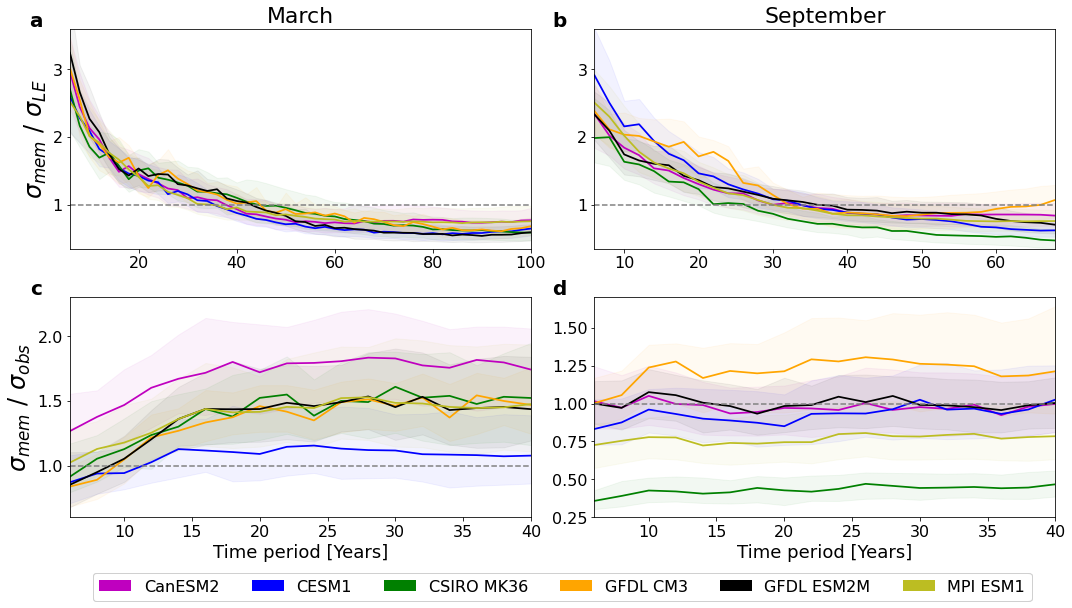

In [147]:
fig, axes = plt.subplots(2,2,figsize=[15,8])

for i, month_ in enumerate([3,9]):
    
    LE_x     = sigmas['LE_0{}_x'.format(month_)]
    mem_2020 = sigmas['mem_0{}_2020'.format(month_)]
    mem_x    = sigmas['mem_0{}_x'.format(month_)]
    obs      = sigmas['obs'].sel(month=month_)
    
    ########### sigma mem / sigma LE ########### 
    for model_i, model_name in enumerate(model_names):
        (mem_x[model_name].median('member') / LE_x[model_name]).plot(ax=axes[0][i], c=colors[model_i], lw=1.75, label=model_print_names[model_i])

        axes[0][i].fill_between(mem_x[model_name]['time_period'], (mem_x[model_name].mean('member')-mem_x[model_name].std('member'))/LE_x[model_name], 
                               (mem_x[model_name].mean('member')+mem_x[model_name].std('member'))/LE_x[model_name], color=colors[model_i], alpha=0.05)

    axes[0][i].axhline(1, c='0.5', linestyle='--')
    axes[0][i].set_ylim(0,3.7)  
    # axes[0][i].set_yticklabels(np.arange(0,3.6,0.5), fontsize=16)
    axes[0][i].set_xlabel('')
    axes[0][i].set_ylabel('')
    # axes[0][i].grid()
    if i==0:
        axes[0][i].set_xlim(6,100)
        axes[0][i].set_xticklabels(np.arange(0,101,20), fontsize=16)
    else:
        axes[0][i].set_xlim(6,68)
        axes[0][i].set_xticklabels(np.arange(0,101,10), fontsize=16)

    ########### sigma mem / sigma obs ########### 
    for model_i, model_name in enumerate(model_names):
        #make the sigma mem and sigma obs the same size if using 1979-2020 obs
        mem_2020 = mem_2020.sel(time_period=slice(6,40))

        (mem_2020[model_name].median('member') / obs).plot(ax=axes[1][i], c=colors[model_i], lw=1.75, label=model_print_names[model_i])

        axes[1][i].fill_between(mem_2020['time_period'], (mem_2020[model_name].mean('member')-mem_2020[model_name].std('member'))/obs, 
                        (mem_2020[model_name].mean('member')+mem_2020[model_name].std('member'))/obs, color=colors[model_i], alpha=0.05)

    axes[1][i].axhline(1, c='0.5', linestyle='--')
    axes[1][i].set_xticklabels(np.arange(5,41,5), fontsize=16)
    axes[1][i].set_xlabel('')
    axes[1][i].set_ylabel('')
    # axes[1][i].grid()
    axes[1][i].set_xlim(6,40)
    
    ########### add features to the whole plot ###########    
legend_elements = [Patch(facecolor=colors[0], label='CanESM2'),
                   Patch(facecolor=colors[1], label='CESM1'),
                   Patch(facecolor=colors[2], label='CSIRO MK36'),
                   Patch(facecolor=colors[3], label='GFDL CM3'),
                   Patch(facecolor=colors[4], label='GFDL ESM2M'),
                   Patch(facecolor=colors[5], label='MPI ESM1'),]

extra_legend = plt.legend(handles=legend_elements, bbox_to_anchor=(-0.07, -0.38), loc='lower center', borderaxespad=0, ncol=6, fontsize=16)
plt.gca().add_artist(extra_legend);

axes[0][0].set_title('March', fontsize=22)
axes[0][1].set_title('September', fontsize=22)
axes[1][0].set_title('')
axes[1][1].set_title('')

axes[0][0].set_ylim(0.35,3.6)
axes[0][1].set_ylim(0.35,3.6)
axes[1][0].set_ylim(0.6,2.3)
axes[1][1].set_ylim(0.25,1.7)

axes[0][0].tick_params(axis='both', which='major', labelsize=16)
axes[0][1].tick_params(axis='both', which='major', labelsize=16)
axes[1][0].tick_params(axis='both', which='major', labelsize=16)
axes[1][1].tick_params(axis='both', which='major', labelsize=16)

axes[0][0].set_ylabel(r'$\sigma_{mem} \ / \ \sigma_{LE}$', fontsize=24)
axes[1][0].set_ylabel(r'$\sigma_{mem} \ / \ \sigma_{obs}$', fontsize=24)
axes[1][0].set_xlabel('Time period [Years]', fontsize=18)
axes[1][1].set_xlabel('Time period [Years]', fontsize=18)

axes[0][0].text(-0.06, 1.08, 'a', transform=axes[0][0].transAxes, fontsize=20, fontweight='bold', va='top', ha='right');
axes[0][1].text(-0.06, 1.08, 'b', transform=axes[0][1].transAxes, fontsize=20, fontweight='bold', va='top', ha='right');
axes[1][0].text(-0.06, 1.08, 'c', transform=axes[1][0].transAxes, fontsize=20, fontweight='bold', va='top', ha='right');
axes[1][1].text(-0.06, 1.08, 'd', transform=axes[1][1].transAxes, fontsize=20, fontweight='bold', va='top', ha='right');

plt.tight_layout()
fig.savefig('/glade/scratch/cwpowell/Synthetic_ensemble_revisions/SIA/figures/Time_period_and_sigma/Ratio_time_period_same_all_models_obs_79_larger_font.pdf', 
            bbox_inches='tight')
# fig.savefig('/glade/scratch/cwpowell/Synthetic_ensemble/SIA/figures/Time_period_and_sigma/Ratio_time_period_same_all_models_obs_79.png', 
#             bbox_inches='tight', dpi=400)

# Trends' effect on $\sigma$

In [45]:
#sigma values linear detrending
sigma_LE_linear  = xr.open_dataset('/glade/campaign/univ/ucub0084/Synthetic_ensemble/SIA/SIA_resampled/Sigma_LE_individual_79-20.nc')
sigma_mem_linear = xr.open_dataset('/glade/campaign/univ/ucub0084/Synthetic_ensemble/SIA/SIA_resampled/Sigma_mem_individual_10000.nc')
sigma_obs_linear = xr.open_dataset('/glade/campaign/univ/ucub0084/Synthetic_ensemble/SIA/SIA_resampled/Sigma_obs_individual_10000.nc')

#sigma values filtering
sigma_LE_filt  = xr.open_dataset('/glade/scratch/cwpowell/Synthetic_ensemble_revisions/SIA/SIA_resampled/Sigma_LE_2yr_filter_10000.nc')
sigma_mem_filt = xr.open_dataset('/glade/scratch/cwpowell/Synthetic_ensemble_revisions/SIA/SIA_resampled/Sigma_mem_2yr_filter_10000.nc')
sigma_obs_filt = xr.open_dataset('/glade/scratch/cwpowell/Synthetic_ensemble_revisions/SIA/SIA_resampled/Sigma_obs_2yr_filter_10000.nc')

In [38]:
#gradients models
SIA = xr.open_dataset(data_path+'SIA/SIA_SIE_SIV/CLIVAR_SIA_1850_2100_RCP85.nc')

model_gradients = {}
for model_i, model_name in enumerate(model_names):
    all_months = []
    for month_ in np.arange(1,13):
        all_mem = []
        for mem_ in np.arange(1,mem_len[model_i]+1):
            all_mem.append(np.polyfit(np.arange(1979,2021), SIA[model_name].sel(time=SIA['time.month']==month_).sel(time=slice('1979','2020')).sel(member=mem_),1)[0])
            
        all_months.append(all_mem)
        
    model_gradients[model_name] = xr.DataArray(data=all_months, coords={'month':np.arange(1,13), 'member':np.arange(1,mem_len[model_i]+1)}, dims=['month','member'])
model_gradients = xr.Dataset(model_gradients)

In [43]:
#gradient LE
LE_gradients = {}
for model_i, model_name in enumerate(model_names):
    all_months = []
    for month_ in np.arange(1,13):
        all_months.append(np.polyfit(np.arange(1979,2021), SIA[model_name].sel(time=SIA['time.month']==month_).sel(time=slice('1979','2020')).mean('member'),1)[0])
                    
    LE_gradients[model_name] = xr.DataArray(data=all_months, coords={'month':np.arange(1,13)}, dims=['month'])
LE_gradients = xr.Dataset(LE_gradients)

In [40]:
#gradients obs
CDR  = xr.open_dataset(data_path+'Raw_data/observations/NSIDC_CDR_v4/SIA_SIE_CDR_BT_NT_79-20_filled.nc')
HadISST1 = xr.open_dataset(data_path+'Raw_data/observations/HadISST/HadISST1_SIA_SIE_79-20_filled.nc')

obs_SIA = xr.Dataset({'CDR':CDR['CDR_SIA'].copy(), 'BT':CDR['BT_SIA'].copy(), 
                      'NT':CDR['NT_SIA'].copy(), 'HadISST1':HadISST1['SIA'].copy()})

obs_gradients = {}
for dataset_name in list(obs_SIA.keys()):
    all_months = []
    for month_ in np.arange(1,13):
        all_months.append(np.polyfit(np.arange(1979,2021), obs_SIA[dataset_name].sel(time=obs_SIA['time.month']==month_).sel(time=slice('1979','2020')),1)[0])
        
    obs_gradients[dataset_name] = xr.DataArray(data=all_months, coords={'month':np.arange(1,13)}, dims=['month'])
obs_gradients = xr.Dataset(obs_gradients)

### Plot $\sigma_{LE}$, $\sigma_{mem}$, $\sigma_{obs}$ verses gradient

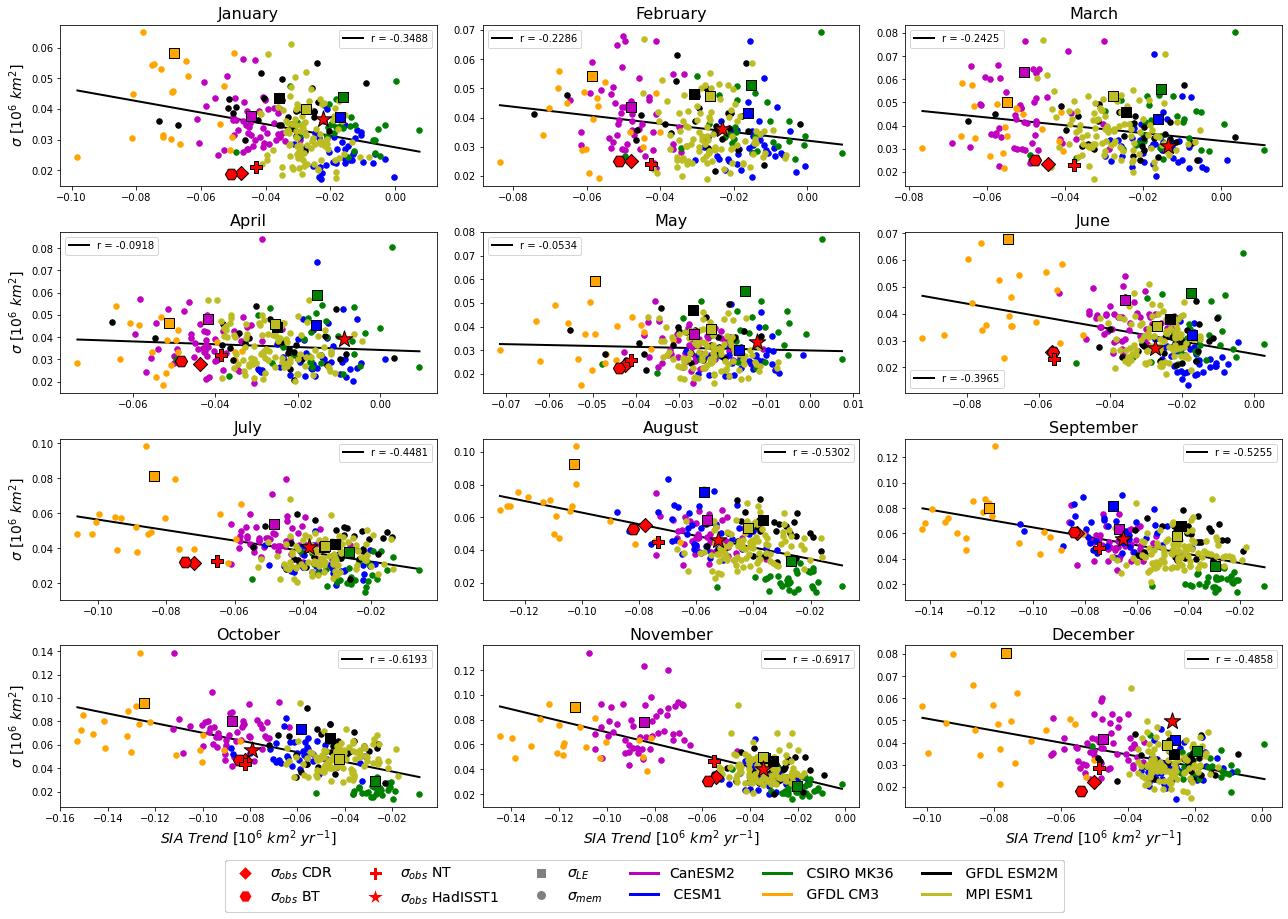

In [90]:
s_y = [0,1,2,0,1,2,0,1,2,0,1,2]
s_x = [0,0,0,1,1,1,2,2,2,3,3,3]

fig, ax = plt.subplots(4,3,figsize=[18,12])

for i, month_ in enumerate(np.arange(1,13,1)):
    
    for model_i, model_name in enumerate(model_names):
        #plot the grad_LE and sigm_LE
        ax[s_x[i]][s_y[i]].scatter(LE_gradients[model_name].sel(month=month_), sigma_LE_linear[model_name].sel(month=month_), 
                                   color=colors[model_i], marker='s', edgecolor='k', s=120, zorder=6)
        
        #plot the grad_mem and sigma_mem
        ax[s_x[i]][s_y[i]].scatter(model_gradients[model_name].sel(month=month_), sigma_mem_linear[model_name].sel(month=month_),
                                   color=colors[model_i], s=30, zorder=5)
        
    #plot the grad_obs and sigma_obs
    marker_list = ['D','H','P','*']
    marker_sizes = [100,150,150,300]
    for dataset_i, dataset_name in enumerate(list(obs_SIA.keys())):
        ax[s_x[i]][s_y[i]].scatter(obs_gradients[dataset_name].sel(month=month_), sigma_obs_linear[dataset_name].sel(month=month_), 
                                   color='r', marker=marker_list[dataset_i], edgecolor='k', s=marker_sizes[dataset_i], zorder=7)
    
    
    #plot the best fit line with r value
    grad_no_nan = np.ravel(model_gradients.to_array().sel(month=month_))[~np.isnan(np.ravel(model_gradients.to_array().sel(month=month_)))]
    sigma_no_nan = np.ravel(sigma_mem_linear.to_array().sel(month=month_))[~np.isnan(np.ravel(model_gradients.to_array().sel(month=month_)))]
    
    coefs_fit = np.polyfit(grad_no_nan, sigma_no_nan, 1)
    x_vals = np.linspace(model_gradients.to_array().sel(month=month_).min(), model_gradients.to_array().sel(month=month_).max(),3)
    r_val = scipy.stats.linregress(grad_no_nan, sigma_no_nan)[2]
    ax[s_x[i]][s_y[i]].plot(x_vals, x_vals*coefs_fit[0] + np.ones(3)*coefs_fit[1], c='k', linewidth=2, label='r = {}'.format(np.round(r_val,4)))

    
    #plot axes details
    if s_y[i] == 0:
        ax[s_x[i]][s_y[i]].set_ylabel(r'$\sigma \ [10^6 \ km^2]$', fontsize=14)
    
    if s_x[i] == 3:
        ax[s_x[i]][s_y[i]].set_xlabel(r'$SIA \ Trend \ [10^6 \ km^2 \ yr^{-1}]$', fontsize=14)
    
    ax[s_x[i]][s_y[i]].set_title(month_names[month_-1],fontsize=16);    
    ax[s_x[i]][s_y[i]].legend()
    
    legend_elements = [Line2D([0], [0], c='1', markerfacecolor='r', marker='D', markersize=10, label=r'$\sigma_{obs}$ CDR'),
                       Line2D([0], [0], c='1', markerfacecolor='r', marker='H', markersize=13, label=r'$\sigma_{obs}$ BT'),
                       Line2D([0], [0], c='1', markerfacecolor='r', marker='P', markersize=13, label=r'$\sigma_{obs}$ NT'),
                       Line2D([0], [0], c='1', markerfacecolor='r', marker='*', markersize=18, label=r'$\sigma_{obs}$ HadISST1'),
                       Line2D([0], [0], c='1', markerfacecolor='0.5', marker='s', markersize=10, label=r'$\sigma_{LE}$'),
                       Line2D([0], [0], c='1', markerfacecolor='0.5', marker='.', markersize=20, label=r'$\sigma_{mem}$'),
                       Line2D([0], [0], color=colors[0], lw=3, label='CanESM2'),
                       Line2D([0], [0], color=colors[1], lw=3, label=' CESM1'),
                       Line2D([0], [0], color=colors[2], lw=3, label=' CSIRO MK36'),
                       Line2D([0], [0], color=colors[3], lw=3, label=' GFDL CM3'),
                       Line2D([0], [0], color=colors[4], lw=3, label=' GFDL ESM2M'),
                       Line2D([0], [0], color=colors[5], lw=3, label=' MPI ESM1')]

    extra_legend = fig.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.06), loc='lower center', borderaxespad=0., fontsize=14, ncol=6)

    plt.gca().add_artist(extra_legend)

plt.tight_layout()
# fig.savefig('/glade/work/cwpowell/CLIVAR_plots/2021/post_COMPS/Trend_verses_sigma.png', dpi=400)

## $\sigma_{LE}$ and $\sigma_{mem}$ for different 42 year time periods

In [7]:
#detrend with a lowpass filter for 42 years starting 1950-1991 ... 2055-2096
anoms_42_rolling = {}
for model_i, model_name in enumerate(model_names):
    print(datetime.datetime.now(), model_name)
    start_yr_list = []
    for start_yr in np.arange(1950,2059,2):
        month_anoms = []
        for month_ in np.arange(1,13):
            mem_anoms = []
            for mem_ in np.arange(1,mem_len[model_i]+1):
                mem_data = SIA_models[model_name].sel(member=mem_).sel(time=SIA_models['time.month']==month_).sel(time=slice(str(start_yr),str(start_yr+41)))
                mem_filt = filt_lowpass(mem_data, sample_freq=1, cutoff=0.25, order=5)
                mem_anoms.append(mem_data - mem_filt)
                
            mem_anoms_xr = xr.concat((mem_anoms),dim='member')
            mem_anoms_xr['time'] = np.arange(0,42)
            month_anoms.append(mem_anoms_xr)
        start_yr_list.append(xr.concat((month_anoms),dim='month'))
            
    anoms_42_rolling[model_name] = xr.concat((start_yr_list),dim='start_year')
anoms_42_rolling = xr.Dataset(anoms_42_rolling)
anoms_42_rolling['member'] = np.arange(1,101)
anoms_42_rolling['month'] = np.arange(1,13)
anoms_42_rolling['start_year'] = np.arange(1950,2059,2)

2022-04-27 13:29:21.920972 CanESM2
2022-04-27 13:32:16.186813 CESM1
2022-04-27 13:34:38.646976 CSIRO_MK36
2022-04-27 13:36:31.847354 GFDL_CM3
2022-04-27 13:37:43.844883 GFDL_ESM2M
2022-04-27 13:39:29.013087 MPI_ESM1


In [18]:
#detrend with a linear trend for 42 years starting 1950-1991 ... 2058-2099
anoms_42_rolling = {}
for model_i, model_name in enumerate(model_names):
    print(datetime.datetime.now(), model_name)
    start_yr_list = []
    for start_yr in np.arange(1950,2059,2):
        month_anoms = []
        for month_ in np.arange(1,13):
            mem_anoms = []
            for mem_ in np.arange(1,mem_len[model_i]+1):
                mem_data = SIA_models[model_name].sel(member=mem_).sel(time=SIA_models['time.month']==month_).sel(time=slice(str(start_yr),str(start_yr+41)))
                coefs = np.polyfit(np.arange(0,42), mem_data, 1)
                mem_anoms.append(mem_data - (np.arange(0,42)*coefs[0] + coefs[1]))
                
            mem_anoms_xr = xr.concat((mem_anoms),dim='member')
            mem_anoms_xr['time'] = np.arange(0,42)
            month_anoms.append(mem_anoms_xr)
        start_yr_list.append(xr.concat((month_anoms),dim='month'))
            
    anoms_42_rolling[model_name] = xr.concat((start_yr_list),dim='start_year')
anoms_42_rolling = xr.Dataset(anoms_42_rolling)
anoms_42_rolling['member'] = np.arange(1,101)
anoms_42_rolling['month'] = np.arange(1,13)
anoms_42_rolling['start_year'] = np.arange(1950,2059,2)

2022-04-27 14:07:07.885752 CanESM2
2022-04-27 14:09:54.033077 CESM1
2022-04-27 14:12:04.187957 CSIRO_MK36
2022-04-27 14:13:43.707700 GFDL_CM3
2022-04-27 14:14:48.978123 GFDL_ESM2M
2022-04-27 14:16:28.073669 MPI_ESM1


In [19]:
# anoms_42_rolling.to_netcdf('/glade/scratch/cwpowell/Synthetic_ensemble_revisions/SIA/CLIVAR_SIA_detrended_42_year_period_start_1950_2058_all_months.nc')
anoms_42_rolling.to_netcdf('/glade/scratch/cwpowell/Synthetic_ensemble_revisions/SIA/CLIVAR_SIA_detrended_42_year_period_start_1950_2058_all_months_linear.nc')

### $\sigma_{LE}$

In [20]:
sigma_LE_rolling_42 = anoms_42_rolling.std('time').std('member')

In [10]:
# sigma_LE_rolling_42.to_netcdf('/glade/scratch/cwpowell/Synthetic_ensemble_revisions/SIA/SIA_resampled/Sigma_LE_2yr_filter_42_yr_1950_2058_all_months.nc')
sigma_LE_rolling_42.to_netcdf('/glade/scratch/cwpowell/Synthetic_ensemble_revisions/SIA/SIA_resampled/Sigma_LE_linear_detrend_42_yr_1950_2058_all_months.nc')
# sigma_LE_rolling_42 = xr.open_dataset('/glade/scratch/cwpowell/Synthetic_ensemble_revisions/SIA/SIA_resampled/Sigma_LE_2yr_filter_42_yr_1950_2058_all_months.nc')

Text(0.5, 0, 'Start Year of 42 year period')

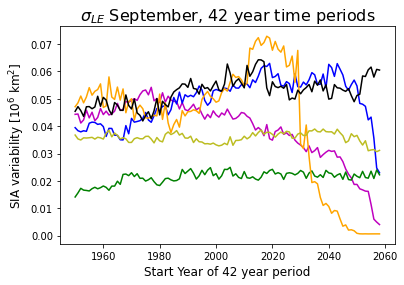

In [70]:
for model_i, model_name in enumerate(model_names):
    sigma_LE_rolling_42[model_name].sel(month=9).plot(c=colors[model_i])
plt.title(r'$\sigma_{LE}$ September, 42 year time periods',fontsize=16);
plt.ylabel(r'SIA variability [10$^6$ km$^2$]',fontsize=12)
plt.xlabel('Start Year of 42 year period',fontsize=12)

Text(0.5, 0, 'Start Year of 42 year period')

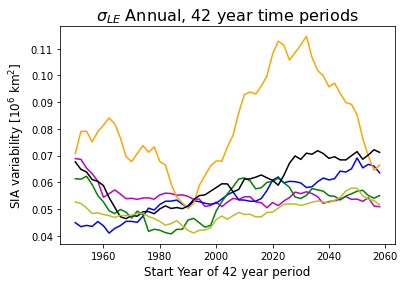

In [21]:
for model_i, model_name in enumerate(model_names):
    sigma_LE_rolling_42[model_name].mean('month').plot(c=colors[model_i])
plt.title(r'$\sigma_{LE}$ Annual, 42 year time periods',fontsize=16);
plt.ylabel(r'SIA variability [10$^6$ km$^2$]',fontsize=12)
plt.xlabel('Start Year of 42 year period',fontsize=12)

### $\sigma_{mem}$

In [22]:
sigma_mem_rolling_42 = {}

for model_i, model_name in enumerate(model_names):
    print(datetime.datetime.now(), model_name)
    
    sigma_mem_month = []
    for month_ in np.arange(1,13):
        print(datetime.datetime.now(), month_)
        
        member_time_periods = []
        for mem_ in np.arange(1,mem_len[model_i]+1):
            
            mem_data = anoms_42_rolling[model_name].sel(month=month_).sel(member=mem_)

            data_start_yr = []
            for start_yr_ in np.arange(1950,2059,2):
                data_start_yr.append(resample_boot2(42, mem_data.sel(start_year=start_yr_), 1000).std('year_i').std('resampling'))
            
            member_time_periods.append(xr.concat((data_start_yr),dim='start_year'))
        
        mem_temp = xr.concat((member_time_periods), dim='member')
        mem_temp['member'] = np.arange(1,mem_len[model_i]+1)
        sigma_mem_month.append(mem_temp)
        
    sigma_mem_rolling_42[model_name] = xr.concat((sigma_mem_month),dim='month')

sigma_mem_rolling_42 = xr.Dataset(sigma_mem_rolling_42)
sigma_mem_rolling_42['start_year'] = np.arange(1950,2059,2)
sigma_mem_rolling_42['month'] = np.arange(1,13)

2022-04-27 14:25:56.926304 CanESM2
2022-04-27 14:25:56.926436 1
2022-04-27 14:26:12.693512 2
2022-04-27 14:26:28.259248 3
2022-04-27 14:26:44.474656 4
2022-04-27 14:27:00.098503 5
2022-04-27 14:27:15.777283 6
2022-04-27 14:27:31.292749 7
2022-04-27 14:27:47.582310 8
2022-04-27 14:28:04.020547 9
2022-04-27 14:28:19.403836 10
2022-04-27 14:28:34.952779 11
2022-04-27 14:28:50.680456 12
2022-04-27 14:29:06.547791 CESM1
2022-04-27 14:29:06.548003 1
2022-04-27 14:29:18.924852 2
2022-04-27 14:29:31.474654 3
2022-04-27 14:29:43.816121 4
2022-04-27 14:29:56.191123 5
2022-04-27 14:30:09.621270 6
2022-04-27 14:30:22.543780 7
2022-04-27 14:30:35.607227 8
2022-04-27 14:30:48.004051 9
2022-04-27 14:31:00.387938 10
2022-04-27 14:31:13.629660 11
2022-04-27 14:31:26.059254 12
2022-04-27 14:31:38.291911 CSIRO_MK36
2022-04-27 14:31:38.292050 1
2022-04-27 14:31:47.730711 2
2022-04-27 14:31:57.052454 3
2022-04-27 14:32:06.866664 4
2022-04-27 14:32:16.230500 5
2022-04-27 14:32:25.576687 6
2022-04-27 14:32:3

In [23]:
sigma_mem_rolling_42.to_netcdf('/glade/scratch/cwpowell/Synthetic_ensemble_revisions/SIA/SIA_resampled/Sigma_mem_linear_detrend_42_yr_1950_2058_resamp_1000_all_months.nc')

In [4]:
# sigma_mem_rolling_42 = xr.open_dataset('/glade/scratch/cwpowell/Synthetic_ensemble_revisions/SIA/SIA_resampled/Sigma_mem_2yr_filter_42_yr_1950_2058_resamp_1000_all_months.nc')

Text(0.5, 0, 'Start Year of 42 year period')

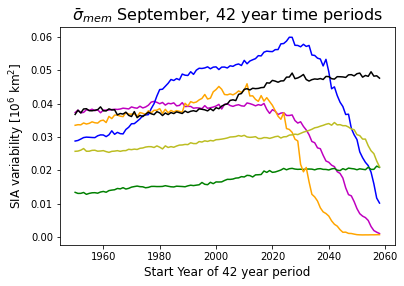

In [63]:
for model_i, model_name in enumerate(model_names):
    sigma_mem_rolling_42[model_name].mean('member').sel(month=9).plot(c=colors[model_i])
plt.title(r'$\bar{\sigma}_{mem}$ September, 42 year time periods',fontsize=16);
plt.ylabel(r'SIA variability [10$^6$ km$^2$]',fontsize=12)
plt.xlabel('Start Year of 42 year period',fontsize=12)

Text(0.5, 0, 'Start Year of 42 year period')

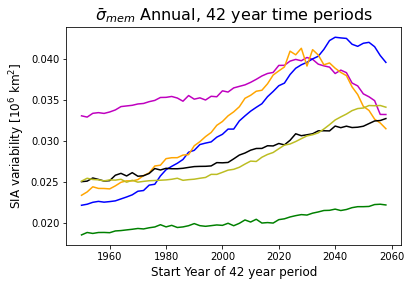

In [14]:
for model_i, model_name in enumerate(model_names):
    sigma_mem_rolling_42[model_name].mean('member').mean('month').plot(c=colors[model_i])
plt.title(r'$\bar{\sigma}_{mem}$ Annual, 42 year time periods',fontsize=16);
plt.ylabel(r'SIA variability [10$^6$ km$^2$]',fontsize=12)
plt.xlabel('Start Year of 42 year period',fontsize=12)

### Plot ratio $\sigma_{mem}$ to $\sigma_{LE}$

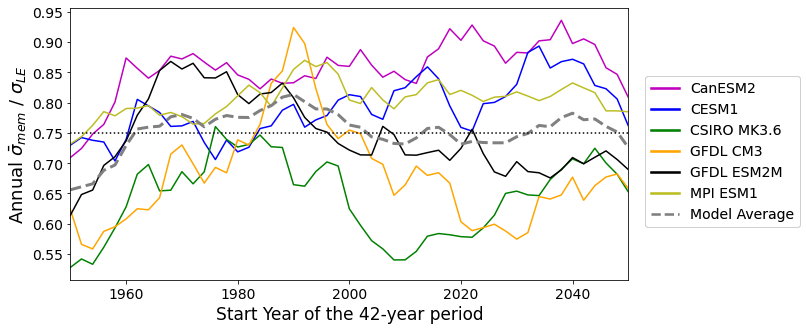

In [62]:
fig = plt.figure(figsize=[10,5])

for model_i, model_name in enumerate(model_names):
    plt.plot(np.arange(1950,2059,2), (sigma_mem_rolling_42[model_name].mean('member')/sigma_LE_rolling_42[model_name]).mean('month'), c=colors[model_i], linewidth=1.5)

plt.plot(np.arange(1950,2059,2),(sigma_mem_rolling_42.to_array().mean('member')/sigma_LE_rolling_42.to_array()).mean('month').mean('variable'), c='0.5', linestyle='--', linewidth=3)

plt.axhline(0.75, c='k', linewidth=1.5, linestyle='dotted')
plt.ylabel(r'Annual $\bar{\sigma}_{mem}$ / $\sigma_{LE}$',fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel('Start Year of the 42-year period',fontsize=17);

plt.xlim(1950,2050)
# plt.axhline(0.75, c='0.5', linestyle='--')

legend_elements = [Line2D([0], [0], c=colors[0], lw=2.5, label='CanESM2'),
                   Line2D([0], [0], c=colors[1], lw=2.5, label='CESM1'),
                   Line2D([0], [0], c=colors[2], lw=2.5, label='CSIRO MK3.6'),
                   Line2D([0], [0], c=colors[3], lw=2.5, label='GFDL CM3'),
                   Line2D([0], [0], c=colors[4], lw=2.5, label='GFDL ESM2M'),
                   Line2D([0], [0], c=colors[5], lw=2.5, label='MPI ESM1'),
                   Line2D([0], [0], c='0.5', lw=2.5, ls='--', label='Model Average')]

extra_legend = plt.legend(handles=legend_elements, bbox_to_anchor=(1.03, 0.75), loc='upper left', borderaxespad=0, ncol=1, fontsize=14)
plt.gca().add_artist(extra_legend);

fig.savefig('/glade/scratch/cwpowell/Synthetic_ensemble_revisions/SIA/figures/Time_period_and_sigma/Ratio_mem_LE_42_year_rolling_1950_2050_linear_detrend.pdf', 
            bbox_inches='tight')

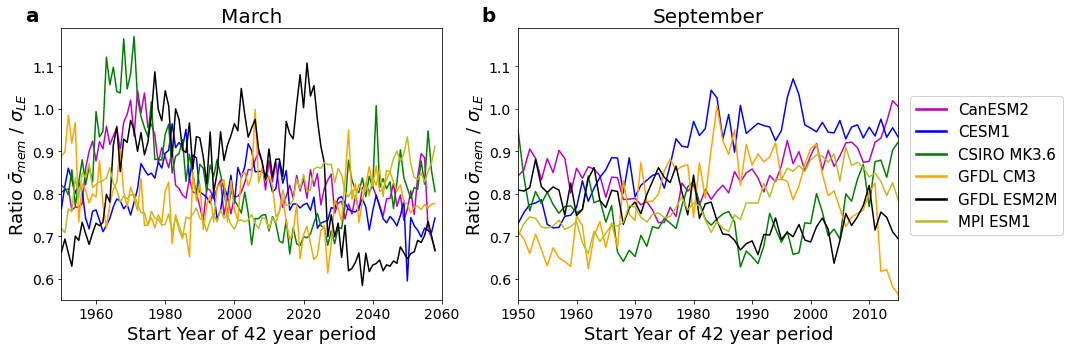

In [36]:
fig, axes = plt.subplots(1,2,figsize=[15,5])

for model_i, model_name in enumerate(model_names):
    axes[0].plot(np.arange(1950,2059,1), sigma_mem_rolling_42[model_name].sel(month=3).mean('member')/sigma_LE_rolling_42[model_name].sel(month=3), c=colors[model_i])
    axes[1].plot(np.arange(1950,2059,1), sigma_mem_rolling_42[model_name].sel(month=9).mean('member')/sigma_LE_rolling_42[model_name].sel(month=9), c=colors[model_i])


axes[0].set_title('March',fontsize=20);
axes[1].set_title('September',fontsize=20);

axes[0].set_ylabel(r'Ratio $\bar{\sigma}_{mem}$ / $\sigma_{LE}$',fontsize=18)
axes[1].set_ylabel(r'Ratio $\bar{\sigma}_{mem}$ / $\sigma_{LE}$',fontsize=18)

axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=14)

axes[0].set_xlabel('Start Year of 42 year period',fontsize=18);
axes[1].set_xlabel('Start Year of 42 year period',fontsize=18);

axes[0].set_xlim(1950,2060)
axes[1].set_xlim(1950,2015)

axes[0].set_ylim(0.55,1.19)
axes[1].set_ylim(0.55,1.19)

axes[0].text(-0.06, 1.08, 'a', transform=axes[0].transAxes, fontsize=20, fontweight='bold', va='top', ha='right');
axes[1].text(-0.06, 1.08, 'b', transform=axes[1].transAxes, fontsize=20, fontweight='bold', va='top', ha='right');

legend_elements = [Line2D([0], [0], c=colors[0], lw=2.5, label='CanESM2'),
                   Line2D([0], [0], c=colors[1], lw=2.5, label='CESM1'),
                   Line2D([0], [0], c=colors[2], lw=2.5, label='CSIRO MK3.6'),
                   Line2D([0], [0], c=colors[3], lw=2.5, label='GFDL CM3'),
                   Line2D([0], [0], c=colors[4], lw=2.5, label='GFDL ESM2M'),
                   Line2D([0], [0], c=colors[5], lw=2.5, label='MPI ESM1')]

extra_legend = plt.legend(handles=legend_elements, bbox_to_anchor=(1.03, 0.75), loc='upper left', borderaxespad=0, ncol=1, fontsize=15)
plt.gca().add_artist(extra_legend);

fig.savefig('/glade/scratch/cwpowell/Synthetic_ensemble_revisions/SIA/figures/Time_period_and_sigma/Ratio_mem_LE_42_year_rolling_1950_2058.pdf', 
            bbox_inches='tight')